<a href="https://colab.research.google.com/github/Ayushi2907/A2OJ-Ladder/blob/master/Asset_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ASSET PRICE PREDICTION**

## **Loading Dataset**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/Google_Stock_Price_Train.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


#### Dataset Overview

We're using historical Google stock price data from Kaggle. First, I checked the shape, column names, and datatypes to understand the structure of the dataset. Then I converted the date column to datetime and sorted the data by date for time series analysis.


In [ ]:
df.shape

(1258, 6)

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [ ]:
df.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,object
Volume,object


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [ ]:
# Converting Date to date datatype
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date')

df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

# making date as the index as date values are unique throughout
df.set_index('Date', inplace=True)

df.dtypes


,0
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64


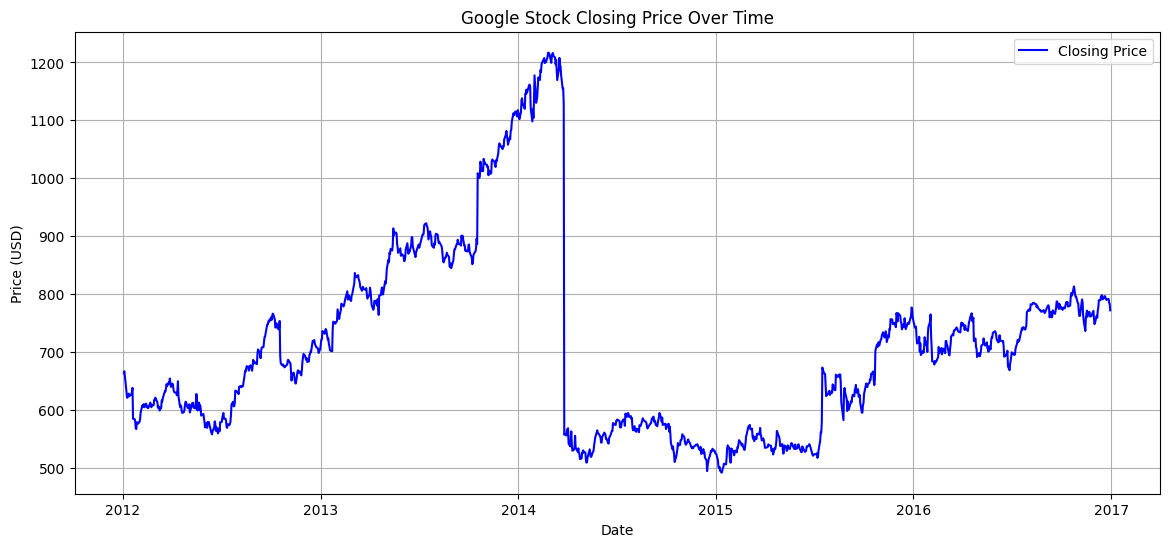

In [ ]:
import matplotlib.pyplot as plt
# Seeing the trend of the closing price
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.title('Google Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Price Trend

This line plot shows the trend of the closing price over time. It clearly shows fluctuations, some uptrends, and a few sharp drops. It helps us see that stock prices are not very stable and change often, which is important for prediction.


## **Feature Engineering**

In [ ]:
# Lag feature (Close price of previous day)
df['Close_t-1'] = df['Close'].shift(1)

# Moving Averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Daily Returns (percentage change)
df['Return_1d'] = df['Close'].pct_change()

# Rolling Volatility (std deviation over 5 days)
df['Volatility_5d'] = df['Close'].rolling(window=5).std()

# Drop rows with NaN values caused by rolling operations
df.dropna(inplace=True)

df.head()

,Open,High,Low,Close,Volume,Close_t-1,MA_5,MA_10,Return_1d,Volatility_5d
Date,,,,,,,,,,
2012-01-17,314.81,314.81,311.67,626.86,3832800.0,623.28,624.748,637.999,0.005744,2.642645
2012-01-18,312.14,315.82,309.90,631.18,5544000.0,626.86,626.698,634.758,0.006891,3.133819
2012-01-19,319.30,319.30,314.55,637.82,12657800.0,631.18,629.412,631.895,0.010520,5.480887
2012-01-20,294.16,294.40,289.76,584.39,21231800.0,637.82,620.706,624.613,-0.083770,21.011561
2012-01-23,291.91,293.23,290.49,583.92,6851300.0,584.39,612.834,618.181,-0.000804,26.470196


To help our models understand the structure and trends in stock prices, we created new features based on past price data:

- **Lag Feature (`Close_t-1`)**:  
  This represents the previous day's closing price. It helps the model learn how today's price might relate to yesterday's.

- **Moving Averages (`MA_5`, `MA_10`)**:  
  These smooth out short-term fluctuations in price by averaging the closing prices over the past 5 and 10 days. They help the model detect short- and medium-term trends.

- **Daily Return (`Return_1d`)**:  
  This is the percentage change in closing price from the previous day. It gives the model information about the stock's momentum.

- **Rolling Volatility (`Volatility_5d`)**:  
  This captures how much the price fluctuated over the past 5 days, using standard deviation. It helps the model account for risk or uncertainty in the stock’s recent behavior.

After creating these features, we dropped the initial rows that had missing values due to rolling window calculations.


### **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Close_t-1', 'MA_5', 'MA_10', 'Return_1d', 'Volatility_5d']
target = 'Close'

X = df[features]
y = df[target]

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.shape, X_test.shape


((999, 5), (250, 5))

#### Train-Test Split

I used 80% of the data for training and 20% for testing. Since this is time series data, I didn’t shuffle the dataset before splitting — this helps keep the time order intact and avoids future data leaking into the past.


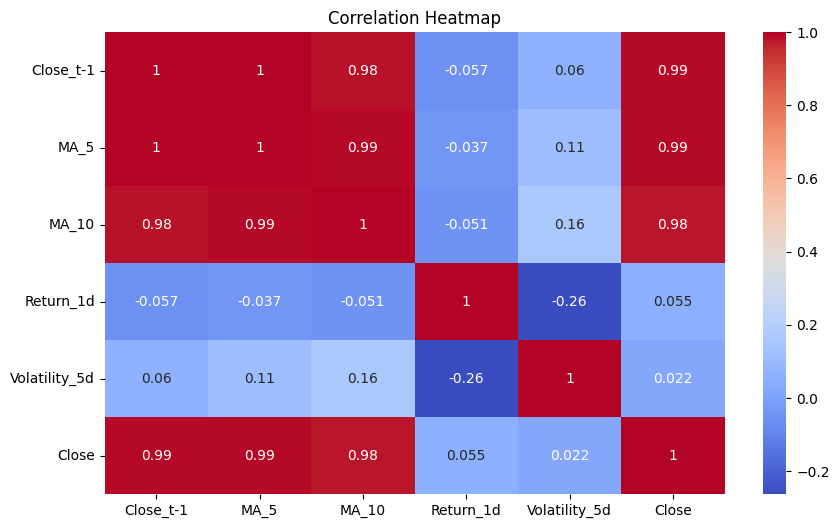

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['Close']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## **MODELLING**

### **Applying Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
lr_pred = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)

print(f"Linear Regression RMSE: {lr_rmse:.2f}")
print(f"Linear Regression MAE: {lr_mae:.2f}")


Linear Regression RMSE: 2.26
Linear Regression MAE: 1.69


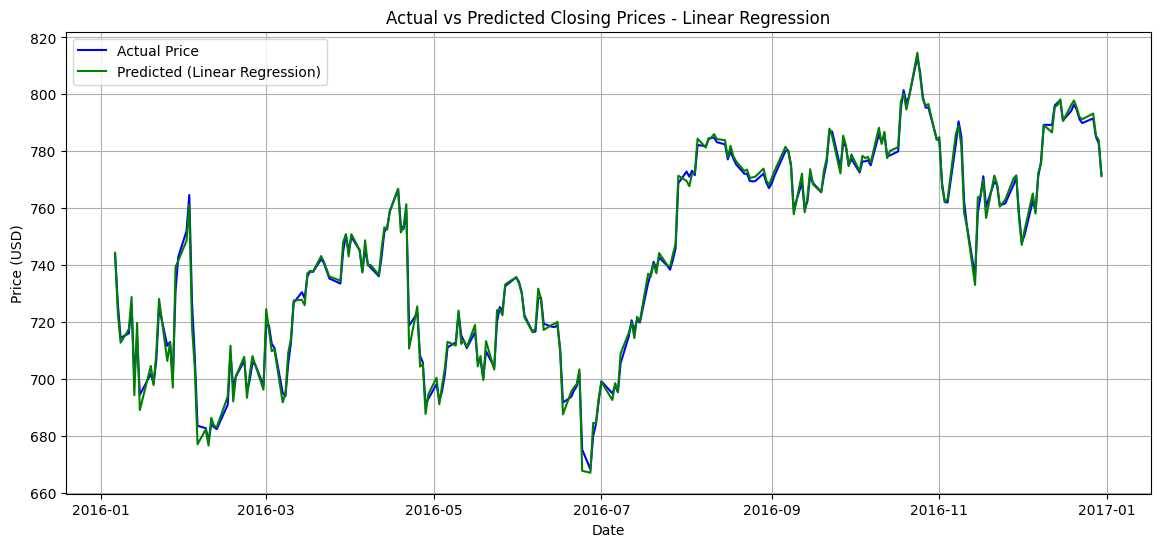

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='blue')
plt.plot(y_test.index, lr_pred, label='Predicted (Linear Regression)', color='green')
plt.title('Actual vs Predicted Closing Prices - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

#### Linear Regression Results

Linear Regression is a simple model, but surprisingly it gave quite good results here. Since we used moving averages and lag features, the data became smooth enough for this model to perform well. The RMSE and MAE were both low, showing accurate predictions.


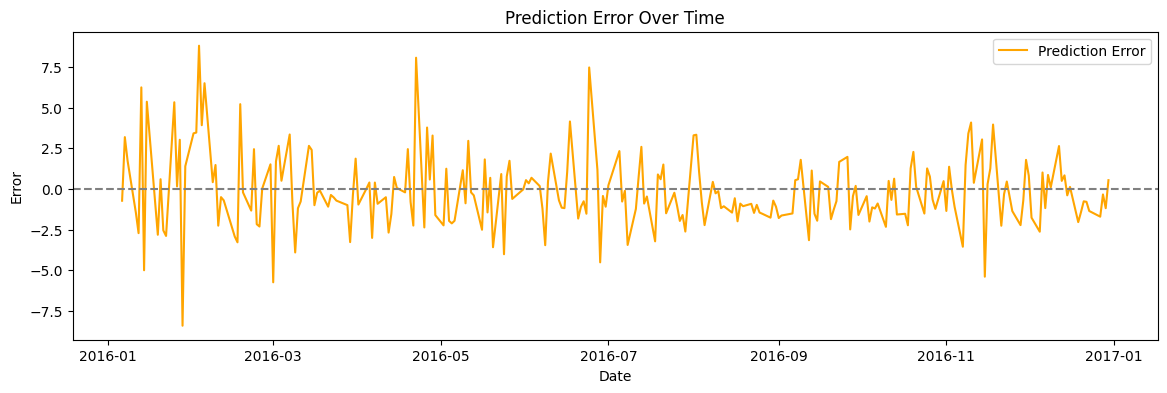

In [ ]:
residuals = y_test - lr_pred

plt.figure(figsize=(14, 4))
plt.plot(y_test.index, residuals, label='Prediction Error', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error Over Time")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()
plt.show()

### **Applying XGBoost**

In [ ]:
import xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initializing model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"xg_RMSE: {rmse:.2f}")
print(f"xg_MAE: {mae:.2f}")


xg_RMSE: 4.24
xg_MAE: 3.30


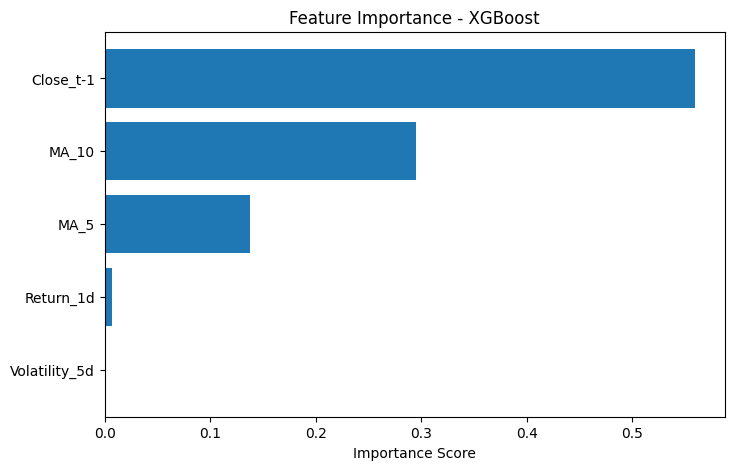

In [ ]:
import matplotlib.pyplot as plt

xgb_importance = model.feature_importances_
sorted_idx = np.argsort(xgb_importance)

plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], xgb_importance[sorted_idx])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.show()

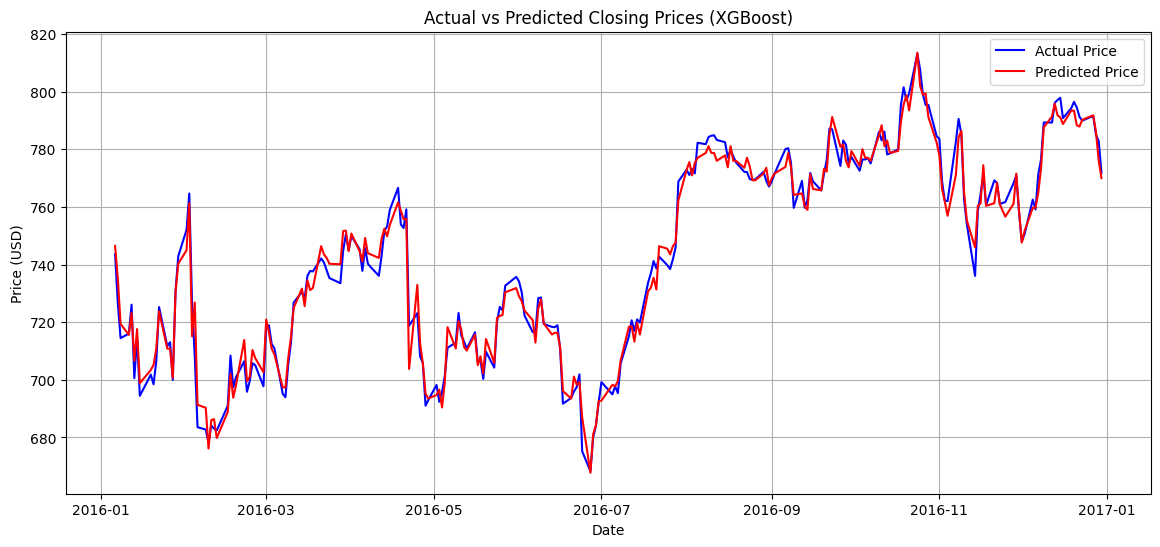

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Closing Prices (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

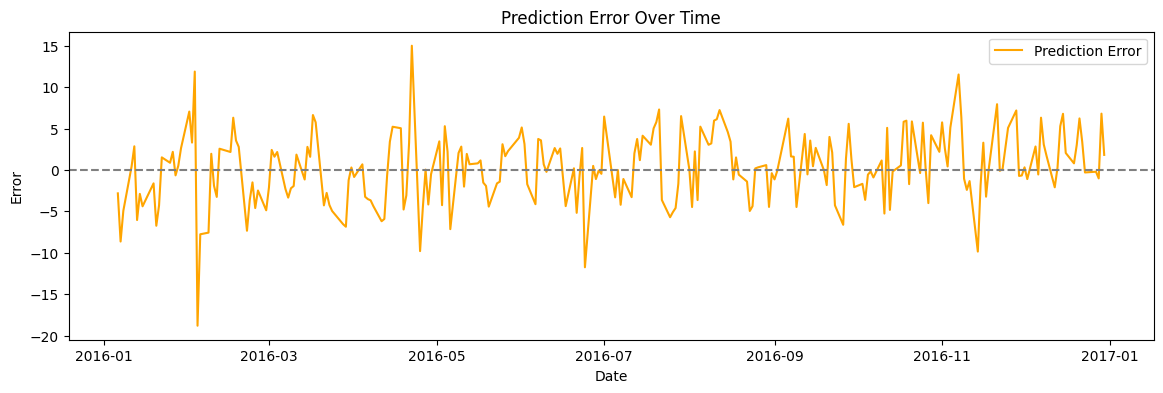

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(14, 4))
plt.plot(y_test.index, residuals, label='Prediction Error', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error Over Time")
plt.xlabel("Date")
plt.ylabel("Error")
plt.legend()
plt.show()

#### XGBoost Results

XGBoost is a more powerful model that usually works better with complex patterns. But in this case, it didn’t perform as well as Linear Regression. This might be because the data is already very smooth and doesn't have enough complexity for XGBoost to take advantage of.


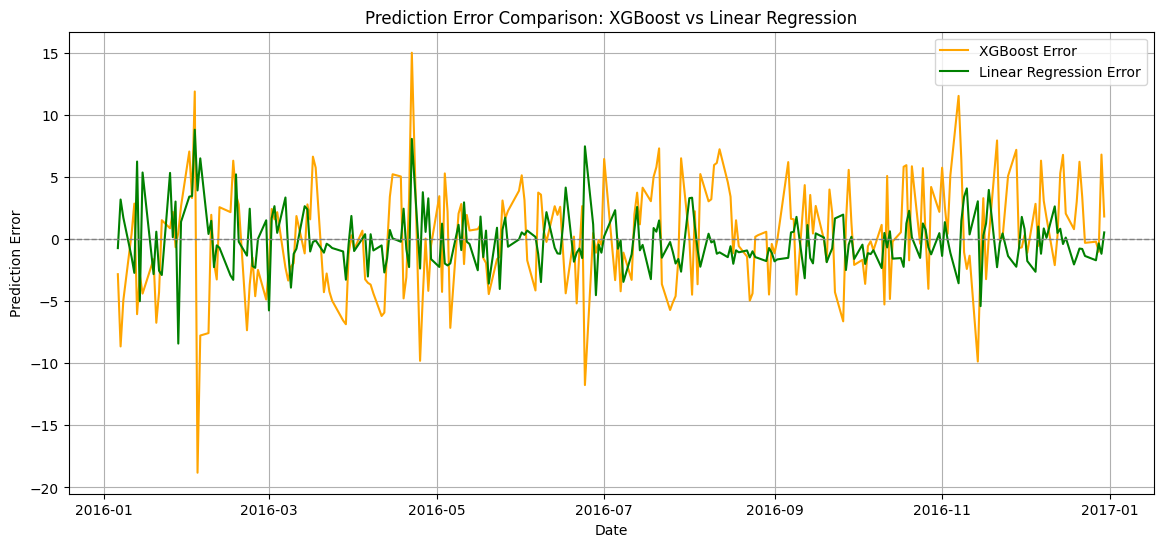

In [ ]:
plt.figure(figsize=(14, 6))

# Residuals (Actual - Predicted)
xgb_residuals = y_test - y_pred
lr_residuals = y_test - lr_pred

# Plotting both errors
plt.plot(y_test.index, xgb_residuals, label='XGBoost Error', color='orange')
plt.plot(y_test.index, lr_residuals, label='Linear Regression Error', color='green')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Prediction Error Comparison: XGBoost vs Linear Regression')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.legend()
plt.grid(True)
plt.show()

#### Error Comparison

This plot shows how far off the predictions were for both models. The green line (Linear Regression) had smaller and more stable errors, while the orange line (XGBoost) had larger fluctuations. This confirms that Linear Regression worked better for this case.


## **Final Conclusion**

In this project, I predicted Google stock prices using two machine learning models: Linear Regression and XGBoost. After cleaning the data and adding new features like moving averages and volatility, I trained both models and compared their results.

Surprisingly, Linear Regression gave better accuracy than XGBoost. This shows that simple models can work well if the data is prepared properly. If I had more time, I would try models like LSTM or ARIMA to see how they perform.

Overall, I learned how to work with time series data, create features, and train models for stock price prediction.
